This notebook source copied from https://www.tensorflow.org/tutorials/keras/text_classification#exercise_multi-class_classification_on_stack_overflow_questions

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [59]:
import matplotlib.pyplot as plt
import os
import re
import string
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [60]:
stack_overflow_dataset_url = r'http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = tf.keras.utils.get_file(fname=r'stack_overflow_16k',
                                  origin=stack_overflow_dataset_url,
                                  untar=True,
                                  cache_dir=r'./stack_overflow',
                                  cache_subdir=r'./stack_overflow')

dataset_dir = os.path.dirname(dataset)


In [61]:
print(dataset_dir)

os.listdir(dataset_dir)

/tmp/.keras/./stack_overflow


['stack_overflow_16k.tar.gz', 'train', 'test', 'README.md']

In [62]:
with open(os.path.join(dataset_dir, r'train', r'python', r'436.txt')) as f:
    print(f.read())

"how to create a tuple of tuples in blank? i want to combine:..a = (1,3,5).b = (2,4,6)...into:..c = ((1,2), (3,4), (5,6))...is there a function that does this in blank?"



In [63]:
batch_size = 32
seed = 42
class_names = (r'csharp', r'java', r'javascript', r'python')

def create_text_dataset(subset):
    return tf.keras.preprocessing.text_dataset_from_directory(
        directory=os.path.join(dataset_dir, r'train'),
        labels=r'inferred',
        label_mode=r'int',
        class_names=class_names,
        batch_size=batch_size,
        max_length=None,
        shuffle=True,
        validation_split=0.2,
        subset=subset,
        seed=seed)

def create_test_dataset():
        return tf.keras.preprocessing.text_dataset_from_directory(
        directory=os.path.join(dataset_dir, r'test'),
        labels=r'inferred',
        label_mode=r'int',
        class_names=class_names,
        batch_size=batch_size,
        max_length=None,
        shuffle=True)

In [64]:
raw_train_ds = create_text_dataset(r'training')

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [65]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Question", text_batch.numpy()[i])
        print("Label", class_names[label_batch.numpy()[i]])


Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [66]:
print("Class names length", len(raw_train_ds.class_names))

print("Label 0", raw_train_ds.class_names[0])
print("Label 1", raw_train_ds.class_names[1])
print("Label 2", raw_train_ds.class_names[2])
print("Label 3", raw_train_ds.class_names[3])

Class names length 4
Label 0 csharp
Label 1 java
Label 2 javascript
Label 3 python


In [67]:
raw_validation_ds = create_text_dataset(r'validation')

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [68]:
raw_test_ds = create_test_dataset()

Found 8000 files belonging to 4 classes.


In [69]:
def custom_standardization(input_data):
    # lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(input_data, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [70]:
max_features = 20000
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode=r'int',
    output_sequence_length=sequence_length,
    pad_to_max_tokens=False)

In [71]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [72]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [73]:
# retrieve a batch (of 32 questions and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized questioin", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of ex

In [74]:
print(r'1287 ---> ', vectorize_layer.get_vocabulary()[1287])
print(r' 313 ---> ', vectorize_layer.get_vocabulary()[313])
print(rf"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

1287 --->  scissors
 313 --->  source
Vocabulary size: 20000


In [75]:
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [76]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [77]:
embedding_dim = 64

class_names_count = len(class_names)

In [78]:
model = tf.keras.Sequential([
        # tf.keras.layers.Embedding(max_features + 1, embedding_dim, mask_zero=True),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(1000),
        # tf.keras.layers.Dense(class_names_count)
        #
        # TODO: 上のレイヤーと下のレイヤーの違いを調べる。
        # TODO: 下のレイヤーだと 'categorical_crossentropy' が動かないが、
        #       SparseCategoricalCrossentropy は動作する理由を調べる。
        tf.keras.layers.Embedding(max_features + 1, embedding_dim, mask_zero=True),
        tf.keras.layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(class_names_count)
    ])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 64)          1280064   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 260       
Total params: 1,300,868
Trainable params: 1,300,868
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            #   loss=r'categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[r'accuracy'])

In [80]:
epochs = 10

history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 6s 27ms/step - loss: 0.7786 - accuracy: 0.6755 - val_loss: 0.6744 - val_accuracy: 0.7431
Epoch 2/10
200/200 [==============================] - 5s 25ms/step - loss: 0.3029 - accuracy: 0.8881 - val_loss: 0.7005 - val_accuracy: 0.7850
Epoch 3/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0731 - accuracy: 0.9734 - val_loss: 0.8129 - val_accuracy: 0.7962
Epoch 4/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 1.0117 - val_accuracy: 0.7919
Epoch 5/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 1.0264 - val_accuracy: 0.7987
Epoch 6/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 1.0953 - val_accuracy: 0.7925
Epoch 7/10
200/200 [==============================] - 5s 25ms/step - loss: 7.7855e-04 - accuracy: 1.0000 - val_loss: 1.1104 - val_accuracy: 0.

In [81]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 1.0923 - accuracy: 0.7976
Loss:  1.09225332736969
Accuracy:  0.7976250052452087


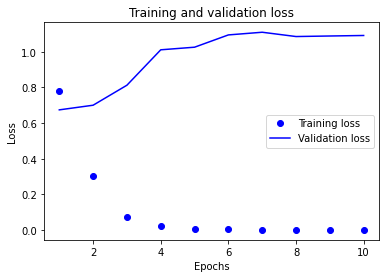

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epoch_range, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epoch_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

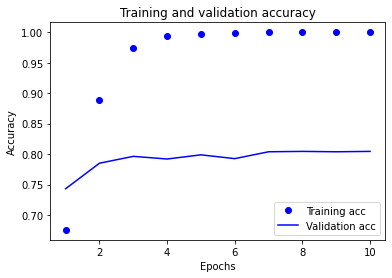

In [83]:
plt.plot(epoch_range, acc, 'bo', label='Training acc')
plt.plot(epoch_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [105]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation(r'sigmoid')
])

export_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=[r'accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 1.0923 - accuracy: 0.7976
0.7976250052452087


In [110]:
examples = [
    "How to import builtin library?",
    "Why public static void main(String[] args) must be defined in class?"
]

predicteds = export_model.predict(examples)

for predicted in predicteds:
    print(dict(zip(class_names, predicted)))

{'csharp': 0.009208918, 'java': 0.99576384, 'javascript': 0.010262191, 'python': 0.9999971}
{'csharp': 0.99998695, 'java': 1.0, 'javascript': 9.593623e-08, 'python': 2.9795255e-12}
